In [ ]:
!pip install gymnasium pyvirtualdisplay matplotlib
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
# Import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display
import gymnasium as gym
from pyvirtualdisplay import Display

In [ ]:
# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# @title Define the grid world environment
# Define the grid world environment
class GridWorld(gym.Env):
    def __init__(self, size=5, traps=[], desired_state=(4, 4)):
        super(GridWorld, self).__init__()
        self.size = size
        self.traps = traps  # List of trap states (e.g., [(1, 1), (2, 2)])
        self.desired_state = desired_state  # Goal state
        self.state = (0, 0)  # Start state
        self.actions = ['up', 'down', 'left', 'right']
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Tuple((gym.spaces.Discrete(size), gym.spaces.Discrete(size)))

    def reset(self):
        """Reset the environment to the start state."""
        self.state = (0, 0)
        return self.state, {}

    def step(self, action):
        """Take an action and return the next state, reward, and done flag."""
        x, y = self.state
        if action == 0 and x > 0:  # up
            x -= 1
        elif action == 1 and x < self.size - 1:  # down
            x += 1
        elif action == 2 and y > 0:  # left
            y -= 1
        elif action == 3 and y < self.size - 1:  # right
            y += 1

        self.state = (x, y)

        # Check if the new state is a trap or the desired state
        if self.state in self.traps:
            reward = -10
            done = True
        elif self.state == self.desired_state:
            reward = 10
            done = True
        else:
            reward = -1
            done = False

        return self.state, reward, done, False, {}

    def render_q_values(self, q_values, title, ax):
        """Render the Q-values."""
        grid = np.zeros((self.size, self.size, 4))
        for state in q_values:
            grid[state] = [q_values[state].get(a, 0) for a in range(self.action_space.n)]

        ax.imshow(np.max(grid, axis=2), cmap='seismic')

        for (i, j) in np.ndindex(self.size, self.size):
            if (i, j) in self.traps:
                ax.text(j, i, 'T', ha='center', va='center', color='white')
            elif (i, j) == self.desired_state:
                ax.text(j, i, 'G', ha='center', va='center', color='white')
            else:
                action = np.argmax(grid[i, j])
                ax.text(j, i, self.actions[action], ha='center', va='center', color='white')

        ax.set_title(title)
        ax.axis('off')

    def render_policy(self, policy, title, ax):
        """Render the policy."""
        grid = np.zeros((self.size, self.size))
        for state in policy:
            grid[state] = policy[state]

        ax.imshow(grid, cmap='viridis')

        for (i, j) in np.ndindex(self.size, self.size):
            if (i, j) in self.traps:
                ax.text(j, i, 'T', ha='center', va='center', color='white')
            elif (i, j) == self.desired_state:
                ax.text(j, i, 'G', ha='center', va='center', color='white')
            else:
                action = policy[i, j]
                ax.text(j, i, self.actions[int(action)], ha='center', va='center', color='white')

        ax.set_title(title)
        ax.axis('off')

In [ ]:
#@title  Action selection methods
def epsilon_greedy(q_values, epsilon):
    """Epsilon-greedy action selection."""
    if random.random() < epsilon:
        # Change here: Ensure action is within valid range
        return random.choice(list(range(len(q_values))))  # Random action
    else:
        return max(q_values, key=q_values.get)  # Greedy action


def softmax(q_values, temperature=1.0):
    """Softmax action selection."""
    exp_values = np.exp(np.array(list(q_values.values())) / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return random.choices(list(q_values.keys()), weights=probabilities)[0]

In [ ]:
# @title Initialize Q Values
def initialize_q_values(env):
    q_values = {}
    for i in range(env.size):
        for j in range(env.size):
            state = (i, j)
            q_values[state] = {a: 0 for a in range(env.action_space.n)}
    return q_values

In [ ]:
# @title Monte-Carlo and TD(0) Algorithms
# Monte-Carlo algorithm
def monte_carlo(env, episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.5,decay_rate=0.01):
    """Monte-Carlo learning algorithm."""
    q_values = initialize_q_values(env)  # Initialize Q-values for all states
    returns = {}  # Dictionary to store returns for each state-action pair

    for episode in range(episodes):
        state, _ = env.reset()
        episode_history = []  # Store (state, action, reward) for the episode

        # Apply decay
        # we chose exponential decay
        epsilon = epsilon * np.exp(-decay_rate * episode)
        while True:
            # Choose an action using policy
            action = epsilon_greedy(q_values[state],epsilon)

            # Step the environment
            next_state,rewarrd,done,_,_= env.step(action)

            # Add necessary information to history
            episode_history.append((state, action, rewarrd))
            if done:
                break
            state = next_state

        # Update Q-values for reversed order of states (from terminal to start)
        G = 0
        for t in reversed(range(len(episode_history))):

            # Unpack the history
            state,action,reward=episode_history[t]

            # Calculate the return G
            G=reward + gamma * G

            # Add G to "returns" dictionary
            if (state, action) not in returns:
                returns[(state, action)] = []

            returns[(state, action)].append(G)

            # Update q_values for this (state, action) pair
            q_values[state][action] = np.mean(returns[(state, action)])
            # incemental update and the returns no need for it
            # q_values[state][action] += alpha * (G - q_values[state][action])

    return q_values

# TD(0) algorithm
def td_zero(env, episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.1,decay_rate=0.01):
    """TD(0) learning algorithm."""
    q_values = initialize_q_values(env)  # Initialize Q-values for all states

    for episode in range(episodes):
        state, _ = env.reset()
        # applay epsilon  deacy
        # we chose exponential decay
        epsilon = epsilon * np.exp(-decay_rate * episode)
        while True:
            # Choose an action using policy
            action = epsilon_greedy(q_values[state],epsilon)

            # Step the environment
            next_state,reward,done,_,_= env.step(action)

            # Calculate the target Q-value

            # target_q_value = reward + gamma * (q_values[next_state][action]) #  ths is based on policy ()
            target_q_value = reward + gamma * max(q_values[next_state].values())

            # Calculate the value error
            value_error = target_q_value - q_values[state][action]

            # Update q_values using TD(0)
            q_values[state][action] += alpha * value_error


            if done:
                break
            state = next_state

    return q_values

In [ ]:
# @title Visualize results
def visualize_results(env, mc_q_values, td_zero_q_values):
    """Visualize the results of Monte-Carlo and TD(0) algorithms."""
    def get_policy(q_values):
        policy = {}
        for state in q_values:
            policy[state] = max(q_values[state], key=q_values[state].get)
        return policy

    mc_policy = get_policy(mc_q_values)
    td_zero_policy = get_policy(td_zero_q_values)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Monte-Carlo Q-values
    env.render_q_values(mc_q_values, "Monte-Carlo Q-values", axes[0, 0])
    # Monte-Carlo Policy
    env.render_policy(mc_policy, "Monte-Carlo Policy", axes[0, 1])
    # TD(0) Q-values
    env.render_q_values(td_zero_q_values, "TD(0) Q-values", axes[1, 0])
    # TD(0) Policy
    env.render_policy(td_zero_policy, "TD(0) Policy", axes[1, 1])

    plt.tight_layout()
    plt.show()

Training with Monte-Carlo...
Monte-Carlo Q-values: {(0, 0): {0: -13.315229280123136, 1: -11.791397542669754, 2: -13.305526650793816, 3: -12.357263745595976}, (0, 1): {0: -11.84442236191804, 1: -10.0, 2: -13.762656897840552, 3: -15.682776918926068}, (0, 2): {0: -18.575251929108262, 1: -14.829954641654346, 2: -12.061983764386826, 3: -22.78822803464522}, (0, 3): {0: -27.14561312162942, 1: -41.25012938814178, 2: -19.224974097833936, 3: -41.05346867676995}, (0, 4): {0: -37.51945352616188, 1: -40.38998361377715, 2: -38.09201101703798, 3: -45.02560817118927}, (1, 0): {0: -12.964080467036455, 1: -12.891581179577885, 2: -11.881784782220654, 3: -10.0}, (1, 1): {0: 0, 1: 0, 2: 0, 3: 0}, (1, 2): {0: -14.1053380657903, 1: -10.0, 2: -10.0, 3: -29.712568853326946}, (1, 3): {0: -43.00525897487873, 1: -26.49049097903257, 2: -10.9, 3: -27.633050228862167}, (1, 4): {0: -41.164821930030946, 1: -40.51226879385751, 2: -22.519624518424227, 3: -47.1212432719833}, (2, 0): {0: -11.794100941021538, 1: -13.901809

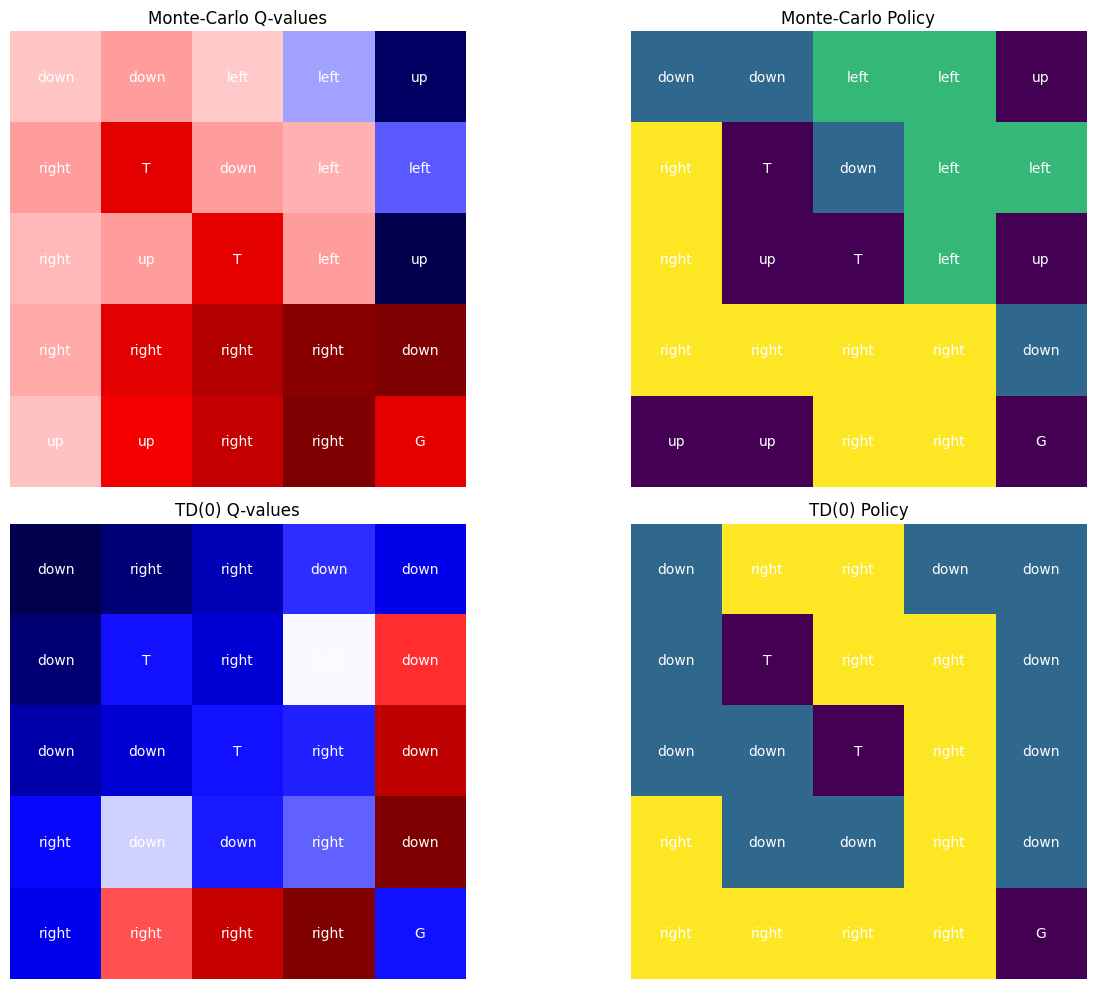

In [ ]:
# @title Train and visualize
env = GridWorld(traps=[(1, 1), (2, 2)], desired_state=(4, 4))

# Train using Monte-Carlo
print("Training with Monte-Carlo...")
mc_q_values = monte_carlo(env, episodes=1000,decay_rate=0)
print("Monte-Carlo Q-values:", mc_q_values)

# Train using TD(0)
print("Training with TD(0)...")
td_zero_q_values = td_zero(env, episodes=100,alpha=0.1,decay_rate=0.001)
print("TD(0) Q-values:", td_zero_q_values)

# Visualize the results
visualize_results(env, mc_q_values, td_zero_q_values)

___

### **Epsilon Decay**  

Epsilon $epsilon$ in **epsilon-greedy** exploration controls the trade-off between exploration (random actions) and exploitation (choosing the best-known action)

A decaying epsilon gradually shifts the agent  behavior from exploration to exploitation over time

---

### **Methods for Epsilon Decay**  

1. **Exponential Decay**  
   $$
   \epsilon_t = \epsilon_0 \cdot e^{-\lambda t}
   $$

   - its rrapid decrease in exploration early on which  leading to faster convergence
   - its use case is when quick exploitation is beneficial, but risks premature convergence to suboptimal policies

2. **Linear Decay**  
   $$
   \epsilon_t = \max(\epsilon_{\text{min}}, \epsilon_0 - \lambda t)
   $$
   - its slower, steady reduction in exploration
   - its use case whenn esures exploration persists longer, useful for complex environments

3. **Inverse Time Decay**  
   $$
   \epsilon_t = \frac{\epsilon_0}{1 + \lambda t}
   $$
   - its efect is: gradual reduction that ensures continued exploration
   - works well for large state spaces where long term exploration is necessary


---

### **Impact of Epsilon Decay on Learning**  

1. **Too Fast Decay**  
   - limits exploration too early
   - rrisks getting stuck in a local optimum
   - reduces algorithm robustness in dynamic environments

2. **Too Slow Decay**  
   - leads to excessive random actions
   - slows down convergence, so  making learning inefficient

3. **Well-Tuned Decay**  
   - balances exploration and exploitation effectively  
   - helps the agent find optimal policies efficiently

----
----
----

## Evaluations to Study
### Agen-Side:
  - Policy for epsilon greedy and softmax
    1. for epsilon-greedy selectionn:

       * its controls the exploration - exploitation trade-off
       * higher epsilon leads to more exploration and  prevent premature convergence to sub optimal policies (prevent to stop in local maxima )

       * lower epsilon increases exploitation, converging faster but maybe  missing the optimal policy by stucking in a local maxima
    2. for softmax selection:
       * its a probabilistic approach to choosing actions based on their Q-values
       * instead of always selecting the action with the highest value (greedy selection) or selecting randomly (pure exploration), so  softmax assigns a probability to each action based on its value
       * by contorling the t paramerter we  results in more uniform action selection fro higer t and for Low t it makes the policy more greedy
       * it can be useful in structured environments when we require a  smooth transitions in policy
    3. so as concolusion
      * epsilon-greedy is easier to implement and works well in simpler environments
      * softmax can help in fine tuned exploration and especially when multiple actions have close Q-values
      

  - Algo. for Q-Leearning and SARSA
    1. for Q-Learning Algo.:
       * its Off-policy method
       * its updates using the max Q-value of the next state
       * its performs better in environments where optimality is the main concern

    2. for SARSA (State-Action-Reward-State-Action):
        * its On-policy method
        * its updates using the next action chosen by the current policy
        * its safer
        * its avoid adventure and exploration of the env ad try to stay safe

  - Convergence for Momnte-Carlo & TD(0) for params Alpha and selection method
    1. for Monte-Carlo:
       * its works with full episode returns , making it less dependent on immediate rewards
       * convergence is slower but generally unbiased
       * alpha (learning rate) affects how much new experiences update Q values
    2. for TD(0):
       * its updates Q values at every step instead of waiting until the end of an episode
       * more sensitive to the alpha parameter since updates are incremental
       * its more biased towards immediate rewards
    3. as conclysion:
        * TD(0) converges faster due to step wise updates but is more biased
        * Monte-Carlo provides unbiased estimates but requires longer training

### Enviroment-Side:
  1.  State sparsity:

        * fro a sparse environment has a high proportion of states that do not contribute meaningful feedback toward optimal learning
        * sparse environments require higher exploration because rewards and useful states are difficult to find so we should use large epsilon to encourages more random actions, "increase exploration"
        * whereas a dense environment provides frequent useful states that accelerate policy discovery
    
  2. Reward system:
    * the reward system heavily influence the  policy learning
    * for dense rewards (incremental small rewards per step), its encourages steady progress but can lead to suboptimal shortcuts
    * sparse rewards (only rewarding goal states), its encourages exploration but slows down learning


## **Summary of Effects**  

| **Adjustment**         | **Effect on Learning** |
|-----------------------|---------------------|
| **Epsilon-Greedy** vs. **Softmax** | Exploration trade-offs, softmax better for fine-tuned control |
| **Q-Learning** vs. **SARSA** | Q-Learning is more aggressive and SARSA is more stable |
| **Monte-Carlo** vs. **TD(0)** | Monte Carlo is unbiased but slow TD(0) is fast but biased |
| **State Sparsity** | Sparse states slow learning so structured environments help |
| **Reward System** | Affects convergence speed, stability, and policy quality |